In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../../../filecoin-mecha-twin/')

from mechafil.data import get_historical_network_stats, \
    get_sector_expiration_stats, \
    query_starboard_supply_stats, \
    get_day_renewed_qa_power_stats, \
    query_starboard_sector_expirations
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

In [3]:
font = {'size' : 10}

matplotlib.rc('font', **font)

## 1. Parameters and other variables

In [4]:
# Units
GIGA = 2**30
MEGA = 1_000_100
EXA = 10**18
EXBI_TO_BYTES = 2**60
BYTES_TO_EXBI = 1./EXBI_TO_BYTES
PEBI_TO_BYTES = 2**50
BYTES_TO_PEBI = 1./PEBI_TO_BYTES
PEBI_TO_EXBI = 1./1024.
EPOCH_PER_DAY = 2880

# constants defined in the filecoin spec: spec.filecoin.io
LAMBDA = np.log(2) / (
    6.0 * 365 * EPOCH_PER_DAY
) 
SIMPLE_ALLOC = 0.3 * 1.1 * 10**9
BASELINE_ALLOC = 0.7 * 1.1 * 10**9
BASELINE_B0 = 2.88888888 * EXBI_TO_BYTES  # initial storage
EPOCH_PER_DAY = 2880
BASELINE_R = np.log(2) / (EPOCH_PER_DAY*365) # 1_051_200 in eopchs

In [5]:
# Data starts in filecoin_daily_stats 2021-03-15
# mainnet went live on 2020-10-15
mainnet_start = datetime.date(2020, 10, 15)

current_date = datetime.date.today() - datetime.timedelta(days=3)  # some of the data comes in a bit slower ... 
current_day = (current_date - mainnet_start).days

start_date = datetime.date(2021, 3, 15) 
start_day = (start_date - mainnet_start).days

# forecasting length in days
# forecast_lenght = 365
# forecast_lenght = 500
forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-03
2024-11-02


In [6]:
# TODO: make these distributions and simulate MC
renewal_rate= 0.6
rb_onboard_power = 12.0
fil_plus_rate = 0.098

duration = 360

In [7]:
offline_dir = './offline_info'
os.makedirs(offline_dir, exist_ok=True)

## 2. Input data

#### Sector scheduled expirations

In [8]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [9]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               386014956.308783
mined_fil                     234402236.389729
vested_fil                     302301927.44663
locked_fil                    134283006.305884
burnt_fil                      33472820.183464
date                                2022-11-03
total_raw_power_eib                  15.992069
total_qa_power_eib                   18.627441
day_onboarded_rb_power_pib            9.511902
day_onboarded_qa_power_pib           22.423278
day_renewed_qa_power_pib             30.858103
Name: 597, dtype: object

In [10]:
fil_stats_df

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,31.176788,30.780540,0.000000
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,32.155762,31.852937,0.000000
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.870209,31.465290,0.000000
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.849304,31.453568,0.000000
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.787598,32.455248,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
593,3.807408e+08,2.332989e+08,3.012300e+08,1.373957e+08,3.345893e+07,2022-10-30,16.426456,19.008181,9.508362,27.920562,31.115140
594,3.822313e+08,2.335827e+08,3.014980e+08,1.364553e+08,3.346076e+07,2022-10-31,16.280976,18.863566,9.245178,22.336073,32.562458
595,3.847145e+08,2.338558e+08,3.017660e+08,1.345081e+08,3.346584e+07,2022-11-01,16.017958,18.629470,9.735138,25.884187,117.858355
596,3.854515e+08,2.341308e+08,3.020339e+08,1.343098e+08,3.347014e+07,2022-11-02,15.986519,18.607665,9.704407,23.461024,28.700998


## 2. Forecast power stats

In [11]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [12]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)
# print(len(power_df))
power_df

,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-03-15,3.310809,3.311754,30.780540,0.000000
1,2021-03-16,3.310809,3.311754,30.780540,0.000000
2,2021-03-17,3.341048,3.341986,31.852937,0.000000
3,2021-03-18,3.369592,3.370540,31.465290,0.000000
4,2021-03-19,3.396884,3.397818,31.453568,0.000000
...,...,...,...,...,...
1323,2024-10-28,11.736955,24.001129,22.584000,56.421599
1324,2024-10-29,11.730153,23.988327,22.584000,53.539141
1325,2024-10-30,11.719796,23.968835,22.584000,63.815644
1326,2024-10-31,11.700946,23.933361,22.584000,88.365083


In [13]:
# power_df and all other dataframes grab data from 2021-03-15 because some derivative data
# is missing. However, to compute minting and rewards properly, we need to compute cumulative sum
# of the power. Since the network began on 2020-10-15, we need to get the power from that timeperiod
# to include it properly into the cumulative sum calculations 
url = f"https://observable-api.starboard.ventures/network_storage_capacity/total_raw_bytes_power"
r = requests.get(url)
history_power_rbp = pd.DataFrame(r.json()["data"])
history_power_rbp["date"] = pd.to_datetime(history_power_rbp["stat_date"])
history_power_rbp['total_raw_bytes_power'] = history_power_rbp['total_raw_bytes_power'].astype(float)

url = f"https://observable-api.starboard.ventures/network_storage_capacity/total_qa_bytes_power"
r = requests.get(url)
history_power_qap = pd.DataFrame(r.json()["data"])
history_power_qap["date"] = pd.to_datetime(history_power_qap["stat_date"])
history_power_qap['total_qa_bytes_power'] = history_power_qap['total_qa_bytes_power'].astype(float)

history_power_rbp = history_power_rbp[history_power_rbp['date'].dt.date < start_date]
history_power_qap = history_power_qap[history_power_qap['date'].dt.date < start_date]

In [14]:
# Get last baseline value from Starboard API
url = f"https://observable-api.starboard.ventures/api/v1/observable/network-storage-capacity/new_baseline_power"
r = requests.get(url)
baseline_power_df = pd.DataFrame(r.json()["data"])
baseline_power_df["date"] = pd.to_datetime(baseline_power_df["stat_date"])
    
init_baseline_bytes = int(baseline_power_df[baseline_power_df["date"] >= pd.to_datetime(start_date, utc="UTC")].iloc[0,1])
init_baseline = init_baseline_bytes*BYTES_TO_EXBI
# init-baseline (b0) just pulls the baseline power and we grab it for the date for which 
# we start the simulation. We could have just used the function and computed it, but in that case
# we need to project out the # of days since the starting point to compute the baseline for that point.

# Baseline function
baseline_growth = float(np.log(2)/365.0)
num_days = end_date-mainnet_start
num_days = num_days.days
baseline_df = pd.DataFrame({
    "index": np.arange(num_days).astype("float"),
    "date": pd.date_range(start=mainnet_start, freq="d", periods=num_days),
})

# Notice that this is in terms of *days*. If you look at the filecoin spec, baseline growth is in units of seconds.
# however, if the time index is in terms of days, and baseline growth is converted to units of days (/365 rather than /[365*24*60*60])
# then it works out to be the same.
baseline_df["total_power"] =  2.88888888 * np.exp(baseline_growth*baseline_df["index"])
baseline_df["power_type"] = "baseline"
baseline_df = baseline_df[["date", "total_power", "power_type"]]
baseline_historical_df = baseline_df[baseline_df['date'] < pd.to_datetime(start_date)]

baseline_fromstart_df = baseline_df[baseline_df['date'] >= pd.to_datetime(start_date)]
baseline_fromstart_df.reset_index(inplace=True)

In [15]:
history_power_rbp['baseline_power_bytes'] = baseline_historical_df['total_power']*EXBI_TO_BYTES
history_power_qap['baseline_power_bytes'] = baseline_historical_df['total_power']*EXBI_TO_BYTES

history_power_rbp['rbp_capped_power'] = np.min(history_power_rbp[['baseline_power_bytes','total_raw_bytes_power']].values,axis=1)
history_power_qap['qap_capped_power'] = np.min(history_power_qap[['baseline_power_bytes','total_qa_bytes_power']].values,axis=1)

rbp_cum_capped_power_beforesimdata = EPOCH_PER_DAY * history_power_rbp['rbp_capped_power'].cumsum()
qap_cum_capped_power_beforesimdata = EPOCH_PER_DAY * history_power_qap['qap_capped_power'].cumsum()

In [16]:
# NOTE: I think the calculations in this cell are in filecoin-mecha-twin/minting.py
# TODO: replace this redundant code with what is in minting.py

def simple_reward_epoch(epoch: float) -> float:
    """
    Exponential decay simple reward
    """
    return SIMPLE_ALLOC * LAMBDA * np.exp(-LAMBDA * epoch)


def baseline_storage(epoch: float) -> float:
    """
    Baseline storage target function
    epoch -- time in 30s second epochs since first mint

    """
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)


def baseline_reward(capped_power: np.array, cum_capped_power: np.array) -> np.array:
    """
    Derivative of cum_baseline_reward_epoch
    """
    a = BASELINE_ALLOC * LAMBDA / BASELINE_B0
    b = capped_power
    c = (1 + (BASELINE_R / BASELINE_B0) * cum_capped_power) ** (1 + LAMBDA / BASELINE_R)
    return a * b / c


def cum_simple_reward(epoch):
    """
    Cumulative exponential decay simple reward
    """
    return SIMPLE_ALLOC * (1 - np.exp(-LAMBDA * epoch))


def network_time(cum_capped_power):
    """ """
    return np.log1p(BASELINE_R * cum_capped_power / BASELINE_B0) / BASELINE_R


def cum_baseline_reward_epoch(network_time):
    """ """
    return BASELINE_ALLOC * (1 - np.exp(-LAMBDA * network_time))

# minting_df.index is in terms of day.
    # day_epoch is the # of epochs in that day.
    #   day-1 = 2880
    #   day-2 = 2880*2
    #   etc...
# simple_reward_epoch is based on lambda, which is with a *30 multiplier. So, our definition of lambda
# takes in epoch.index and internally converts to seconds.index
delta_datastart_mainnetstart = start_date - mainnet_start
power_df['day_epoch'] = EPOCH_PER_DAY * (np.array(list(power_df.index)) + delta_datastart_mainnetstart.days)  
power_df['simple_reward_epoch'] = EPOCH_PER_DAY * power_df['day_epoch'].pipe(simple_reward_epoch)
power_df['cum_simple_reward'] = power_df['day_epoch'].pipe(cum_simple_reward)
power_df['baseline_storage'] = power_df['day_epoch'].pipe(baseline_storage)*BYTES_TO_EXBI

power_df['rbp_capped_power'] = np.min(power_df[['baseline_storage','total_raw_power_eib']].values,axis=1)*EXBI_TO_BYTES
power_df['qap_capped_power'] = np.min(power_df[['baseline_storage','total_qa_power_eib']].values,axis=1)*EXBI_TO_BYTES

# *****************************************************************
#  NOTE!: rbp_cum_capped_power_beforesimdata.iloc[-1] gets the cumulative capped power
#  from dates [2020-10-15, 2021-03-14].  The remainder of the dataframes start from
#  date 2021-03-15 because some of the additional data required for computing
#  minting, vesting, only started being aggregated in starboard from 2021-03-15
power_df['rbp_cum_capped_power'] = EPOCH_PER_DAY * power_df['rbp_capped_power'].cumsum() + rbp_cum_capped_power_beforesimdata.iloc[-1]
power_df['qap_cum_capped_power'] = EPOCH_PER_DAY * power_df['qap_capped_power'].cumsum() + qap_cum_capped_power_beforesimdata.iloc[-1]
# *****************************************************************

power_df['rbp_network_time'] = power_df['rbp_cum_capped_power'].pipe(network_time)
power_df['qap_network_time'] = power_df['qap_cum_capped_power'].pipe(network_time)

power_df['rbp_cum_baseline_reward'] = power_df['rbp_network_time'].pipe(cum_baseline_reward_epoch)
power_df['qap_cum_baseline_reward'] = power_df['qap_network_time'].pipe(cum_baseline_reward_epoch)

power_df['rbp_cum_network_reward'] = power_df['rbp_cum_baseline_reward'] + power_df['cum_simple_reward']
power_df['qap_cum_network_reward'] = power_df['qap_cum_baseline_reward'] + power_df['cum_simple_reward']

power_df['rbp_network_reward'] = power_df['simple_reward_epoch'] + \
                                        EPOCH_PER_DAY * baseline_reward(power_df['rbp_capped_power'], power_df['rbp_cum_capped_power'])
power_df['qap_network_reward'] = power_df['simple_reward_epoch'] + \
                                        EPOCH_PER_DAY * baseline_reward(power_df['qap_capped_power'], power_df['qap_cum_capped_power'])

In [17]:
rb_crossing_above = power_df[power_df["total_raw_power_eib"] > baseline_fromstart_df["total_power"]]["date"].iloc[0]
power_df_afterfirstcrossing = power_df[power_df['date'] > pd.to_datetime(rb_crossing_above)]
baseline_df_afterfirstcrossing = baseline_fromstart_df[baseline_fromstart_df['date'] > pd.to_datetime(rb_crossing_above)]
rb_crossing_below = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_raw_power_eib"] < baseline_df_afterfirstcrossing["total_power"]]["date"].iloc[0]
qa_crossing_below = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_qa_power_eib"] < baseline_df_afterfirstcrossing["total_power"]]["date"].iloc[0]

print(rb_crossing_above)
print(rb_crossing_below)
print(qa_crossing_below)

2021-04-08
2023-02-13
2023-12-29


<IPython.core.display.Javascript object>


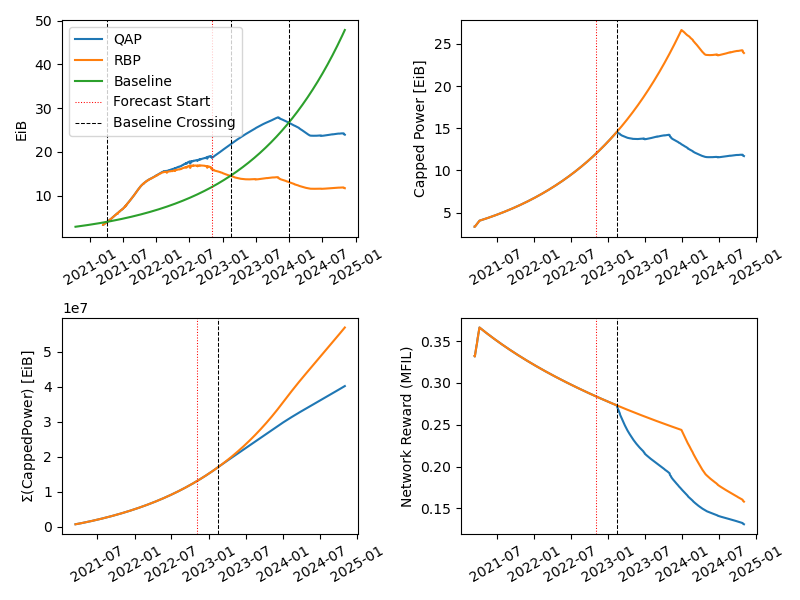

In [18]:
fig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.plot(baseline_df['date'], baseline_df['total_power'], label='Baseline')

plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75, label='Forecast Start')
plt.axvline(rb_crossing_above, color='black', linestyle='--', lw=0.75, label='Baseline Crossing')
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75)
plt.axvline(qa_crossing_below, color='black', linestyle='--', lw=0.75)

plt.xticks(rotation=30)
plt.ylabel("EiB")
plt.legend()
# plt.show()

plt.subplot(2,2,2)
plt.plot(power_df['date'], power_df['rbp_capped_power']*BYTES_TO_EXBI, label='RBP Capped Power')
plt.plot(power_df['date'], power_df['qap_capped_power']*BYTES_TO_EXBI, label='QAP Capped Power')

plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75)
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel('Capped Power [EiB]')

plt.subplot(2,2,3)
plt.plot(power_df['date'], power_df['rbp_cum_capped_power']*BYTES_TO_EXBI, label='SUM(RBP Capped Power)')
plt.plot(power_df['date'], power_df['qap_cum_capped_power']*BYTES_TO_EXBI, label='SUM(QAP Capped Power)')

plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75)
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel('$\Sigma$(CappedPower) [EiB]')

plt.subplot(2,2,4)
plt.plot(power_df['date'], power_df['rbp_network_reward']/MEGA, label='RBP Network Reward')
plt.plot(power_df['date'], power_df['qap_network_reward']/MEGA, label='QAP Network Reward')

plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75)
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel('Network Reward (MFIL)')

fig.tight_layout()

<IPython.core.display.Javascript object>


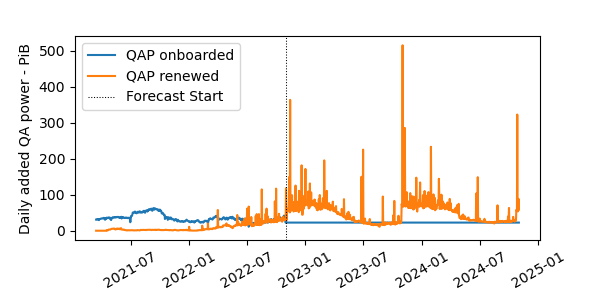

In [19]:
f = plt.figure(figsize=(6,3))
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='k', linestyle=':', lw=0.75, label='Forecast Start')

plt.xticks(rotation=30)
plt.ylabel("Daily added QA power - PiB")
plt.legend()
plt.show()
plt.subplots_adjust(bottom=0.2)

fig.tight_layout()

## 3. Forecast Vesting

In [20]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)
display(vest_df)

,date,total_vest
151,2021-03-15,1.020450e+08
152,2021-03-16,1.026464e+08
153,2021-03-17,1.032478e+08
154,2021-03-18,1.038492e+08
155,2021-03-19,1.044506e+08
...,...,...
1474,2024-10-28,4.694064e+08
1475,2024-10-29,4.695890e+08
1476,2024-10-30,4.697717e+08
1477,2024-10-31,4.699543e+08


<IPython.core.display.Javascript object>


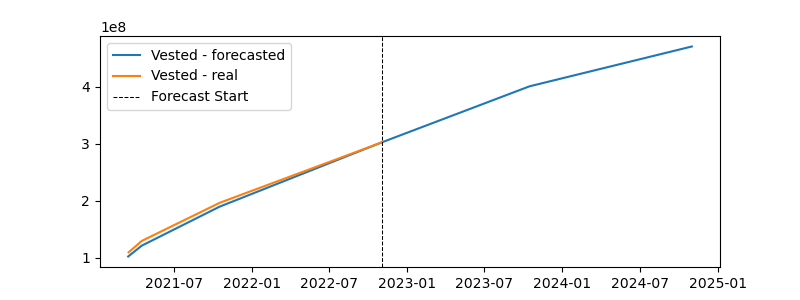

In [21]:
plt.figure(figsize=(8,3))
plt.plot(vest_df['date'], vest_df['total_vest'], label="Vested - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['vested_fil'],label="Vested - real")
plt.axvline(vest_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75, label='Forecast Start')

plt.legend()
plt.show()

## 4. Forecast minting stats and baseline

In [22]:
# This is the same as the calculations above, so need to merge the two cells
# to avoid inconsistencies

rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

mint_df

,days,date,network_RBP,network_QAP,day_onboarded_power_QAP,day_renewed_power_QAP,cum_simple_reward,network_baseline,capped_power,cum_capped_power,network_time,cum_baseline_reward,cum_network_reward,day_network_reward,network_QAP_growth,network_RBP_growth,network_QAP_percentgrowth_day,network_RBP_percentgrowth_day
0,151,2021-03-15,3.817103e+18,3.818192e+18,3.465581e+16,0.000000e+00,1.540053e+07,4.248358e+18,3.817103e+18,3.023795e+20,83.757717,2.014434e+07,3.554487e+07,331303.719846,0.000000e+00,0.000000e+00,0.000000,0.000000
1,152,2021-03-16,3.817103e+18,3.818192e+18,3.465581e+16,0.000000e+00,1.550008e+07,4.256434e+18,3.817103e+18,3.061966e+20,84.734330,2.037609e+07,3.587617e+07,331303.719846,0.000000e+00,0.000000e+00,0.000000,0.000000
2,153,2021-03-17,3.851966e+18,3.853047e+18,3.586322e+16,0.000000e+00,1.559961e+07,4.264525e+18,3.851966e+18,3.100485e+20,85.718029,2.060945e+07,3.620905e+07,332881.549782,3.485465e+16,3.486311e+16,0.009046,0.009051
3,154,2021-03-18,3.884875e+18,3.885968e+18,3.542677e+16,0.000000e+00,1.569910e+07,4.272631e+18,3.884875e+18,3.139334e+20,86.708275,2.084428e+07,3.654338e+07,334329.620491,3.292098e+16,3.290859e+16,0.008472,0.008471
4,155,2021-03-19,3.916341e+18,3.917418e+18,3.541357e+16,0.000000e+00,1.579857e+07,4.280752e+18,3.916341e+18,3.178497e+20,87.704660,2.108050e+07,3.687906e+07,335679.800444,3.144980e+16,3.146613e+16,0.008028,0.008035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1474,2024-10-28,1.353179e+19,2.767142e+19,2.542732e+16,6.352507e+16,1.230322e+08,5.240247e+19,1.353179e+19,1.578561e+22,1212.526431,2.454089e+08,3.684410e+08,133001.290802,-1.692272e+16,-8.991884e+15,-0.000612,-0.000665
1324,1475,2024-10-29,1.352395e+19,2.765666e+19,2.542732e+16,6.027971e+16,1.230976e+08,5.250208e+19,1.352395e+19,1.579913e+22,1212.932301,2.454763e+08,3.685739e+08,132880.785496,-1.475915e+16,-7.842270e+15,-0.000534,-0.000580
1325,1476,2024-10-30,1.351200e+19,2.763419e+19,2.542732e+16,7.185003e+16,1.231631e+08,5.260188e+19,1.351200e+19,1.581264e+22,1213.337500,2.455435e+08,3.687066e+08,132740.099148,-2.247269e+16,-1.194086e+16,-0.000813,-0.000884
1326,1477,2024-10-31,1.349027e+19,2.759329e+19,2.542732e+16,9.949024e+16,1.232286e+08,5.270187e+19,1.349027e+19,1.582613e+22,1213.741737,2.456106e+08,3.688392e+08,132551.004230,-4.089950e+16,-2.173194e+16,-0.001482,-0.001611


<IPython.core.display.Javascript object>


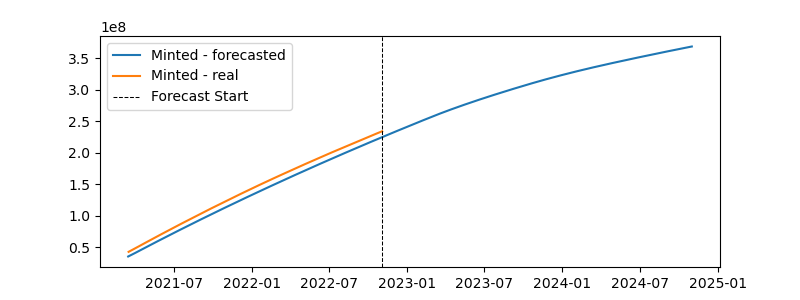

In [23]:
plt.figure(figsize=(8,3))
plt.plot(mint_df['date'], mint_df['cum_network_reward'], label="Minted - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['mined_fil'],label="Minted - real")
plt.axvline(mint_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75, label='Forecast Start')
plt.legend()
plt.show()

## 5. Compute circulating supply

In [24]:
fil_stats_df
# len(burnt_fil_vec)

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,31.176788,30.780540,0.000000
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,32.155762,31.852937,0.000000
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.870209,31.465290,0.000000
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.849304,31.453568,0.000000
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.787598,32.455248,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
593,3.807408e+08,2.332989e+08,3.012300e+08,1.373957e+08,3.345893e+07,2022-10-30,16.426456,19.008181,9.508362,27.920562,31.115140
594,3.822313e+08,2.335827e+08,3.014980e+08,1.364553e+08,3.346076e+07,2022-10-31,16.280976,18.863566,9.245178,22.336073,32.562458
595,3.847145e+08,2.338558e+08,3.017660e+08,1.345081e+08,3.346584e+07,2022-11-01,16.017958,18.629470,9.735138,25.884187,117.858355
596,3.854515e+08,2.341308e+08,3.020339e+08,1.343098e+08,3.347014e+07,2022-11-02,15.986519,18.607665,9.704407,23.461024,28.700998


In [25]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_date,
    current_date,
    end_date,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)

cil_df

,days_x,date,circ_supply,network_gas_burn,day_locked_pledge,network_locked_pledge,network_locked,network_locked_reward,disbursed_reserve,days_y,...,cum_capped_power,network_time,cum_baseline_reward,cum_network_reward,day_network_reward,network_QAP_growth,network_RBP_growth,network_QAP_percentgrowth_day,network_RBP_percentgrowth_day,total_vest
0,151,2021-03-15,1.011143e+08,1.916571e+07,0.000000,2.456517e+07,4.913035e+07,2.456517e+07,1.706662e+07,151,...,3.023795e+20,83.757717,2.014434e+07,3.554487e+07,331303.719846,0.000000e+00,0.000000e+00,0.000000,0.000000,1.020450e+08
1,152,2021-03-16,8.699668e+07,1.919340e+07,532672.914490,2.472193e+07,4.939911e+07,2.467718e+07,1.706662e+07,152,...,3.061966e+20,84.734330,2.037609e+07,3.587617e+07,331303.719846,0.000000e+00,0.000000e+00,0.000000,0.000000,1.026464e+08
2,153,2021-03-17,8.761796e+07,1.925624e+07,497222.159428,2.485953e+07,4.964928e+07,2.478974e+07,1.706662e+07,153,...,3.100485e+20,85.718029,2.060945e+07,3.620905e+07,332881.549782,3.485465e+16,3.486311e+16,0.009046,0.009051,1.032478e+08
3,154,2021-03-18,8.824998e+07,1.930788e+07,488698.424237,2.499858e+07,4.990135e+07,2.490277e+07,1.706662e+07,154,...,3.139334e+20,86.708275,2.084428e+07,3.654338e+07,334329.620491,3.292098e+16,3.290859e+16,0.008472,0.008471,1.038492e+08
4,155,2021-03-19,8.891224e+07,1.934878e+07,518524.283727,2.511908e+07,5.013526e+07,2.501618e+07,1.706662e+07,155,...,3.178497e+20,87.704660,2.108050e+07,3.687906e+07,335679.800444,3.144980e+16,3.146613e+16,0.008028,0.008035,1.044506e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1474,2024-10-28,5.451161e+08,5.087142e+07,337398.724503,2.376204e+08,2.589265e+08,2.130604e+07,1.706662e+07,1474,...,1.578561e+22,1212.526431,2.454089e+08,3.684410e+08,133001.290802,-1.692272e+16,-8.991884e+15,-0.000612,-0.000665,4.694064e+08
1324,1475,2024-10-29,5.455067e+08,5.089539e+07,324592.475981,2.375401e+08,2.588274e+08,2.128733e+07,1.706662e+07,1475,...,1.579913e+22,1212.932301,2.454763e+08,3.685739e+08,132880.785496,-1.475915e+16,-7.842270e+15,-0.000534,-0.000580,4.695890e+08
1325,1476,2024-10-30,5.459287e+08,5.091935e+07,371633.745340,2.374283e+08,2.586969e+08,2.126863e+07,1.706662e+07,1476,...,1.581264e+22,1213.337500,2.455435e+08,3.687066e+08,132740.099148,-2.247269e+16,-1.194086e+16,-0.000813,-0.000884,4.697717e+08
1326,1477,2024-10-31,5.464402e+08,5.094332e+07,505931.006173,2.372268e+08,2.584766e+08,2.124988e+07,1.706662e+07,1477,...,1.582613e+22,1213.741737,2.456106e+08,3.688392e+08,132551.004230,-4.089950e+16,-2.173194e+16,-0.001482,-0.001611,4.699543e+08


<IPython.core.display.Javascript object>


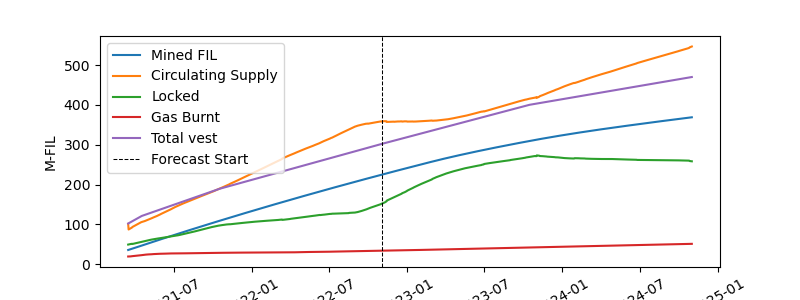

In [26]:
plt.figure(figsize=(8,3))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")

plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75, 
            label='Forecast Start')
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


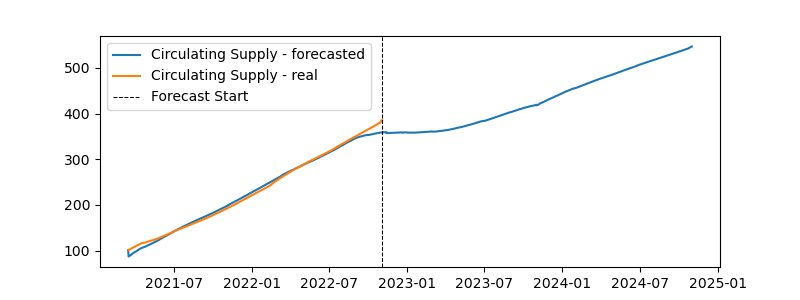

In [27]:
plt.figure(figsize=(8,3))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75, label='Forecast Start')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


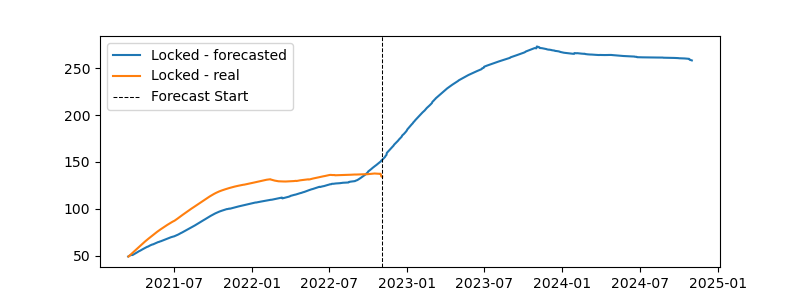

In [28]:
plt.figure(figsize=(8,3))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75, 
            label='Forecast Start')
plt.legend()
plt.show()

### Compute FoFR

In [29]:
def compute_sector_pledge(s, m, q, sector_df):
    # Get relevant variables
    qa_power_zero = sector_df["network_QAP"].iloc[0]
    circ_supply_zero = sector_df["circ_supply"].iloc[0]
    day_rewards_zero = sector_df["day_network_reward"].iloc[0]
    # compute pledge
    numerator = m * s * (20.0 * day_rewards_zero +  q * circ_supply_zero)
    pledge = numerator/qa_power_zero
    return pledge

def compute_sector_gas(d):
    total_gas = 0.00363 + 0.0119 + 0.00358 * (d/365.0)
    return total_gas

def compute_sector_rewards(s, m, sector_df):
    # Get relevant variables
    qa_power = sector_df["network_QAP"].values
    circ_supply = sector_df["circ_supply"].values
    day_rewards = sector_df["day_network_reward"].values
    # compute rewards
    total_rewards = sum(day_rewards[1:] / qa_power[1:])
    sector_rewards = m * s * total_rewards
    return sector_rewards
    
def compute_annualized_fofr_for_sector(seal_day, s, d, m, q, df):
    # Filter data to get sector days
    sector_df = df[df["days"].between(seal_day, seal_day+d)].sort_values("days").reset_index(drop=True)
    # Compute sector rewards, gas and pledge
    rewards = compute_sector_rewards(s, m, sector_df)
    gas = compute_sector_gas(d)
    pledge = compute_sector_pledge(s, m, q, sector_df)
    # Compute annualized return
    total_return = (rewards-gas+pledge)/pledge
    d_years = float(d)/365.0
    annualized_return = (total_return)**(1/d_years)-1
    return annualized_return, pledge

def compute_annualized_fofr_path(sector_size, sector_d, sector_fil_m, filtered_df):
    lock_target = filtered_df["lock_target"].iloc[0]
    duration_slope = filtered_df["slope"].iloc[0]
    if duration_slope is None:
        sector_m = sector_fil_m
    else:
        sector_m = sector_fil_m * duration_slope * (sector_d/365)
    fofr_list = []
    pledge_list = []
    for seal_day in filtered_df["days"][:-sector_d].values:
        fofr, pledge = compute_annualized_fofr_for_sector(seal_day, sector_size, sector_d, sector_m, lock_target, filtered_df)
        fofr_list.append(fofr)
        pledge_list.append(pledge)
    d = sector_d/365
    fofr_df = pd.DataFrame({
        "date": pd.to_datetime(filtered_df["date"].iloc[:-sector_d].values),
        "fofr": fofr_list,
        "total_fofr": (np.array(fofr_list)+1)**d-1,
        "lock_target": filtered_df["lock_target"].iloc[:-sector_d].values,
        "avg_dur": filtered_df["avg_dur"].iloc[:-sector_d].values,
        "slope": filtered_df["slope"].iloc[:-sector_d].values,
        "pledge": pledge_list,
    })
    return fofr_df

def compute_annualized_fofr_for_df(df, sector_size, sector_d, sector_fil_m):
    fofr_list = []
    n_sims = int(len(df)/N_DAYS)
    for i in range(n_sims):
        start = N_DAYS * i
        end = N_DAYS * (i+1)
        filtered_df = df.iloc[start:end]
#         print('sim=%d' % (i,), filtered_df['date'].iloc[0], filtered_df['date'].iloc[-1])
        sim_fofr_df = compute_annualized_fofr_path(sector_size, sector_d, sector_fil_m, filtered_df)
        fofr_list.append(sim_fofr_df)
    fofr_df = pd.concat(fofr_list)
    return fofr_df

In [30]:
fofr_df_rbp = power_df[['date', 'total_qa_power_eib', 'day_epoch', 'rbp_network_reward', 'qap_network_reward']]
fofr_df_rbp['network_QAP'] = fofr_df_rbp['total_qa_power_eib']*EXBI_TO_BYTES
fofr_df_rbp['day_network_reward'] = fofr_df_rbp['rbp_network_reward']
fofr_df_rbp['duration_m'] = 'base'
fofr_df_rbp['lock_target'] = 0.3
fofr_df_rbp['avg_dur'] = 1
fofr_df_rbp['slope'] = 1
fofr_df_rbp['circ_supply'] = cil_df['circ_supply']
fofr_df_rbp['days'] = fofr_df_rbp['day_epoch']/EPOCH_PER_DAY

fofr_df_qap = power_df[['date', 'total_qa_power_eib', 'day_epoch', 'rbp_network_reward', 'qap_network_reward']]
fofr_df_qap['network_QAP'] = fofr_df_qap['total_qa_power_eib']*EXBI_TO_BYTES
fofr_df_qap['day_network_reward'] = fofr_df_qap['qap_network_reward']
fofr_df_qap['duration_m'] = 'base'
fofr_df_qap['lock_target'] = 0.3
fofr_df_qap['avg_dur'] = 1
fofr_df_qap['slope'] = 1
fofr_df_qap['circ_supply'] = cil_df['circ_supply']
fofr_df_qap['days'] = fofr_df_qap['day_epoch']/EPOCH_PER_DAY

print(len(fofr_df_rbp))

1328


In [31]:
fofr_df_qap
#datetime.date(2021,3,15) - datetime.date(2020,10,15)

,date,total_qa_power_eib,day_epoch,rbp_network_reward,qap_network_reward,network_QAP,day_network_reward,duration_m,lock_target,avg_dur,slope,circ_supply,days
0,2021-03-15,3.311754,434880,332069.332800,332129.772008,3.818192e+18,332129.772008,base,0.3,1,1,1.011143e+08,151.0
1,2021-03-16,3.311754,437760,331534.383302,331594.559167,3.818192e+18,331594.559167,base,0.3,1,1,8.699668e+07,152.0
2,2021-03-17,3.341986,440640,333111.160128,333170.505028,3.853047e+18,333170.505028,base,0.3,1,1,8.761796e+07,153.0
3,2021-03-18,3.370540,443520,334558.140958,334617.919026,3.885968e+18,334617.919026,base,0.3,1,1,8.824998e+07,154.0
4,2021-03-19,3.397818,446400,335907.199417,335965.676380,3.917418e+18,335965.676380,base,0.3,1,1,8.891224e+07,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2024-10-28,24.001129,4245120,131755.412709,159095.526645,2.767142e+19,159095.526645,base,0.3,1,1,5.451161e+08,1474.0
1324,2024-10-29,23.988327,4248000,131637.689283,158901.625952,2.765666e+19,158901.625952,base,0.3,1,1,5.455067e+08,1475.0
1325,2024-10-30,23.968835,4250880,131500.157753,158682.244445,2.763419e+19,158682.244445,base,0.3,1,1,5.459287e+08,1476.0
1326,2024-10-31,23.933361,4253760,131315.117046,158401.472399,2.759329e+19,158401.472399,base,0.3,1,1,5.464402e+08,1477.0


In [32]:
sector_size = 32 * GIGA
sector_d = int(365/1.)   # sector duration
sector_fil_m = 10.0
N_DAYS = len(fofr_df_rbp)  # TODO: I'm not sure what is the correct configuration of this??

base_1y_fil_df_rbp_network_reward = compute_annualized_fofr_for_df(fofr_df_rbp, sector_size, sector_d, sector_fil_m)
base_1y_fil_df_qap_network_reward = compute_annualized_fofr_for_df(fofr_df_qap, sector_size, sector_d, sector_fil_m)
print(len(base_1y_fil_df_rbp_network_reward), len(base_1y_fil_df_qap_network_reward))

963 963


<IPython.core.display.Javascript object>


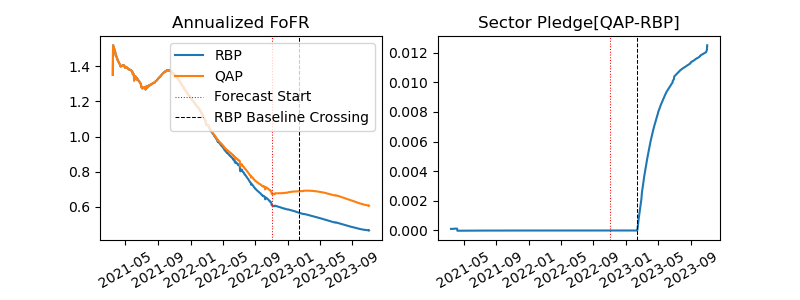

In [33]:
f = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(base_1y_fil_df_rbp_network_reward['date'], base_1y_fil_df_rbp_network_reward['fofr'], label='RBP')
plt.plot(base_1y_fil_df_qap_network_reward['date'], base_1y_fil_df_qap_network_reward['fofr'], label='QAP')
plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75, label='Forecast Start')
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75, label='RBP Baseline Crossing')
plt.xticks(rotation=30)
plt.legend()
plt.title('Annualized FoFR')

ax = plt.subplot(1,2,2)
plt.plot(base_1y_fil_df_qap_network_reward['date'], base_1y_fil_df_qap_network_reward['pledge']-base_1y_fil_df_rbp_network_reward['pledge'])
plt.axvline(power_df['date'][current_day-start_day-1], color='r', linestyle=':', lw=0.75, label='Forecast Start')
plt.axvline(rb_crossing_below, color='black', linestyle='--', lw=0.75, label='RBP Baseline Crossing')
plt.xticks(rotation=30)
plt.title('Sector Pledge[QAP-RBP]')

plt.subplots_adjust(bottom=0.2)
fig.tight_layout()